In [28]:
from model.classifer import SimpleCNN, SimpleMLP
from data.classifer_loader import CaptchaClassifierDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import os

In [40]:
# Training configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 18
ANNOTATION_FILE = "yolo.txt"
IMG_DIR = "."
MODEL_SAVE_PATH = "checkpoints"

print(f"Using device: {DEVICE}")

# Create model
model = SimpleMLP(num_classes=10)
model = model.to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
Model parameters: 577,178


In [41]:
# Create dataset and data loaders
def create_classifier_dataloader(annotation_file, img_dir, batch_size=32, shuffle=True, target_size=(28, 28)):
    """
    Create a DataLoader for character classification
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Grayscale normalization
    ])
    
    dataset = CaptchaClassifierDataset(
        annotation_file=annotation_file,
        img_dir=img_dir,
        transform=transform,
        target_size=target_size
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    
    return dataloader

# Create dataset and split into train/validation
full_dataset = CaptchaClassifierDataset(
    annotation_file=ANNOTATION_FILE,
    img_dir=IMG_DIR,
    target_size=(28, 28)
)

# Split dataset (80% train, 20% validation)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Total samples: {dataset_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Loaded 2000 character samples from yolo.txt
That's 400 images with 5 characters each
Total samples: 2000
Training samples: 1600
Validation samples: 400
Training batches: 25
Validation batches: 7


In [42]:
# Create dataset and split into train/validation
full_dataset = CaptchaClassifierDataset(
    annotation_file=ANNOTATION_FILE,
    img_dir=IMG_DIR,
    target_size=(28, 28)
)

# Split dataset (80% train, 20% validation)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Total samples: {dataset_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Loaded 2000 character samples from yolo.txt
That's 400 images with 5 characters each
Total samples: 2000
Training samples: 1600
Validation samples: 400
Training batches: 25
Validation batches: 7


In [43]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Create checkpoint directory
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Training tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0

In [44]:
# Training loop
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 50)
    
    # Training phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Print progress
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    # Calculate training metrics
    train_loss = running_train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # Calculate validation metrics
    val_loss = running_val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    
    # Update learning rate
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Print epoch results
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'best_val_acc': best_val_acc
        }, f'{MODEL_SAVE_PATH}/best_classifiermlp.pth')
        print(f'New best model saved with validation accuracy: {best_val_acc:.2f}%')
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 1 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'best_val_acc': best_val_acc
        }, f'{MODEL_SAVE_PATH}/classifiermlp_epoch_{epoch+1}.pth')

print(f'\nTraining completed!')
print(f'Best validation accuracy: {best_val_acc:.2f}%')


Epoch 1/18
--------------------------------------------------
Batch 0/25, Loss: 2.3453
Train Loss: 2.2837, Train Acc: 12.88%
Val Loss: 2.1234, Val Acc: 27.00%
Learning Rate: 0.001000
New best model saved with validation accuracy: 27.00%

Epoch 2/18
--------------------------------------------------
Batch 0/25, Loss: 2.1465
Train Loss: 1.9218, Train Acc: 25.25%
Val Loss: 1.4725, Val Acc: 48.25%
Learning Rate: 0.001000
New best model saved with validation accuracy: 48.25%

Epoch 3/18
--------------------------------------------------
Batch 0/25, Loss: 1.7098
Train Loss: 1.4341, Train Acc: 43.38%
Val Loss: 0.7963, Val Acc: 71.75%
Learning Rate: 0.001000
New best model saved with validation accuracy: 71.75%

Epoch 4/18
--------------------------------------------------
Batch 0/25, Loss: 1.2229
Train Loss: 1.1204, Train Acc: 56.69%
Val Loss: 0.4444, Val Acc: 90.25%
Learning Rate: 0.001000
New best model saved with validation accuracy: 90.25%

Epoch 5/18
------------------------------------

Selected random indices: [226, 330, 104, 398, 167, 83, 312, 342]


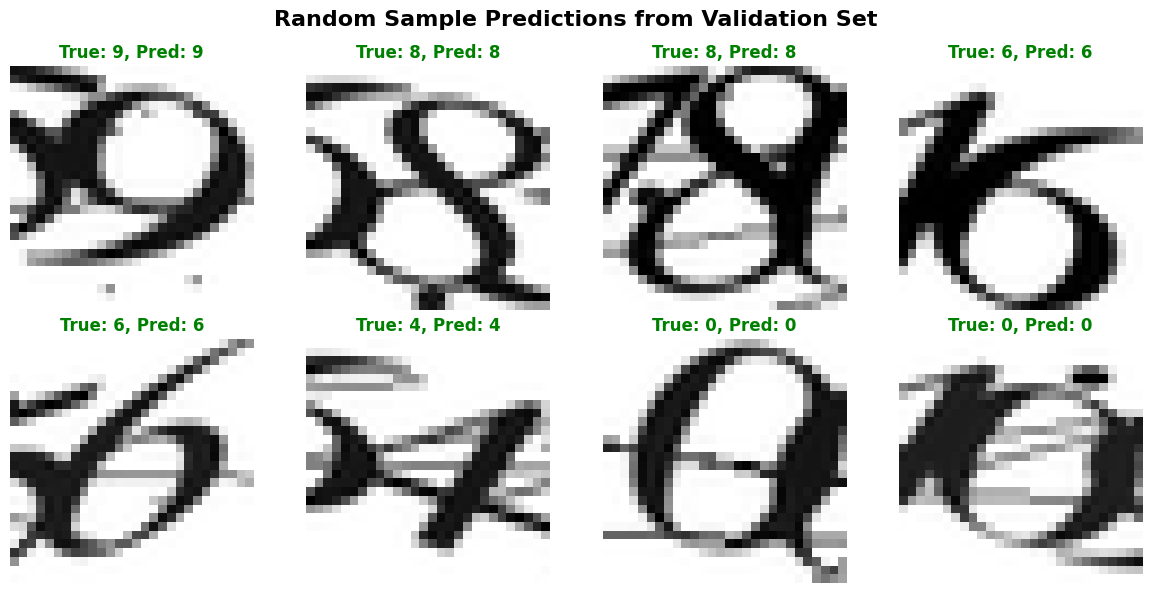


Accuracy on 8 random samples: 100.0% (8/8)


In [45]:
# Test the trained model on random samples
model.eval()
test_samples = 8

# Collect all validation data first
all_images = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        all_images.append(images)
        all_labels.append(labels)

# Concatenate all batches
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Randomly select test_samples indices
import random
total_val_samples = len(all_images)
random_indices = random.sample(range(total_val_samples), min(test_samples, total_val_samples))

print(f"Selected random indices: {random_indices}")

# Get random samples
random_images = all_images[random_indices].to(DEVICE)
random_labels = all_labels[random_indices].to(DEVICE)

# Get predictions
with torch.no_grad():
    outputs = model(random_images)
    _, predictions = torch.max(outputs, 1)

# Move to CPU for visualization
random_images = random_images.cpu()
random_labels = random_labels.cpu()
predictions = predictions.cpu()

# Plot results
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(test_samples):
    row = i // 4
    col = i % 4
    
    # Denormalize image
    img = random_images[i].squeeze().numpy()
    img = (img * 0.5) + 0.5  # Reverse normalization
    img = np.clip(img, 0, 1)
    
    axes[row, col].imshow(img, cmap='gray')
    
    # Color code: green for correct, red for incorrect
    true_label = random_labels[i].item()
    pred_label = predictions[i].item()
    
    if true_label == pred_label:
        axes[row, col].set_title(f'True: {true_label}, Pred: {pred_label}', color='green', fontweight='bold')
    else:
        axes[row, col].set_title(f'True: {true_label}, Pred: {pred_label}', color='red', fontweight='bold')
    
    axes[row, col].axis('off')

plt.suptitle('Random Sample Predictions from Validation Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{MODEL_SAVE_PATH}/random_test_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print accuracy for these random samples
correct = (random_labels == predictions).sum().item()
accuracy = 100 * correct / test_samples
print(f"\nAccuracy on {test_samples} random samples: {accuracy:.1f}% ({correct}/{test_samples})")

In [46]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, save_path=None):
    """
    Plot training and validation loss and accuracy curves
    """
    epochs = range(1, len(train_losses) + 1)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot Loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add annotations for best validation loss
    best_val_loss_idx = val_losses.index(min(val_losses))
    best_val_loss_epoch = epochs[best_val_loss_idx]
    best_val_loss = val_losses[best_val_loss_idx]
    
    ax1.annotate(f'Best Val Loss: {best_val_loss:.4f}\nat Epoch {best_val_loss_epoch}',
                xy=(best_val_loss_epoch, best_val_loss),
                xytext=(best_val_loss_epoch + 2, best_val_loss + 0.1),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
    
    # Plot Accuracy curves
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    
    # Add annotations for best validation accuracy
    best_val_acc_idx = val_accuracies.index(max(val_accuracies))
    best_val_acc_epoch = epochs[best_val_acc_idx]
    best_val_acc = val_accuracies[best_val_acc_idx]
    
    ax2.annotate(f'Best Val Acc: {best_val_acc:.2f}%\nat Epoch {best_val_acc_epoch}',
                xy=(best_val_acc_epoch, best_val_acc),
                xytext=(best_val_acc_epoch + 2, best_val_acc - 10),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training curves saved to: {save_path}")
    
    plt.show()
    
    # Print training summary
    print("\nTraining Summary:")
    print("-" * 50)
    print(f"Total Epochs: {len(epochs)}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
    print(f"Best Validation Loss: {best_val_loss:.4f} at Epoch {best_val_loss_epoch}")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}% at Epoch {best_val_acc_epoch}")
    
    # Check for overfitting
    final_train_acc = train_accuracies[-1]
    final_val_acc = val_accuracies[-1]
    acc_gap = final_train_acc - final_val_acc
    
    if acc_gap > 10:
        print(f"\n⚠️  Warning: Potential overfitting detected!")
        print(f"   Training-Validation accuracy gap: {acc_gap:.2f}%")
    elif acc_gap > 5:
        print(f"\n⚠️  Moderate overfitting detected.")
        print(f"   Training-Validation accuracy gap: {acc_gap:.2f}%")
    else:
        print(f"\n✅ Good generalization! Training-Validation gap: {acc_gap:.2f}%")

def plot_detailed_training_analysis(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Create a more detailed training analysis with multiple subplots
    """
    epochs = range(1, len(train_losses) + 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Loss Curves', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Accuracy curves
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Accuracy Curves', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    
    # 3. Learning progress (loss difference)
    loss_diff = [abs(t - v) for t, v in zip(train_losses, val_losses)]
    ax3.plot(epochs, loss_diff, 'g-', linewidth=2, marker='o', markersize=3)
    ax3.set_title('Train-Validation Loss Gap', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('|Train Loss - Val Loss|')
    ax3.grid(True, alpha=0.3)
    
    # 4. Accuracy gap analysis
    acc_diff = [t - v for t, v in zip(train_accuracies, val_accuracies)]
    colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in acc_diff]
    ax4.bar(epochs, acc_diff, color=colors, alpha=0.7, width=0.8)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax4.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='Moderate Overfitting (5%)')
    ax4.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='High Overfitting (10%)')
    ax4.set_title('Overfitting Analysis (Train - Val Accuracy)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy Difference (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{MODEL_SAVE_PATH}/detailed_training_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Add this to your existing training cell after the training loop:

Generating training curves...
Training curves saved to: checkpoints/training_curves.png


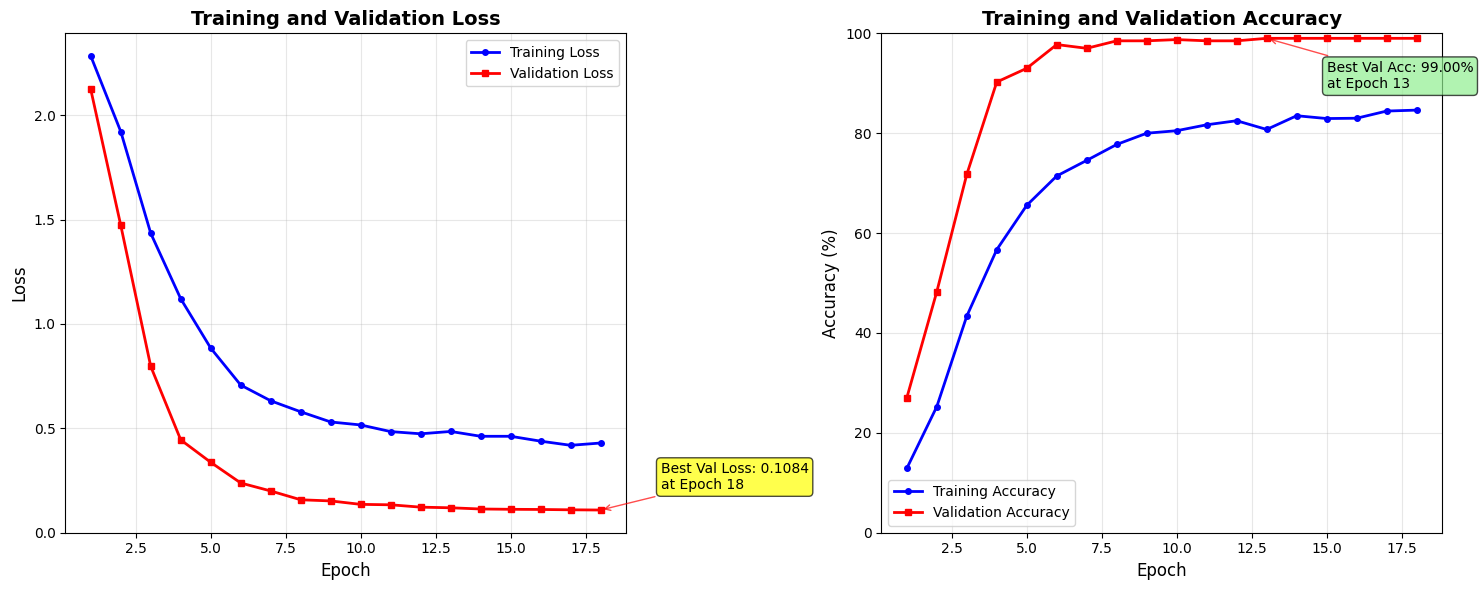


Training Summary:
--------------------------------------------------
Total Epochs: 18
Final Training Loss: 0.4295
Final Validation Loss: 0.1084
Final Training Accuracy: 84.62%
Final Validation Accuracy: 99.00%
Best Validation Loss: 0.1084 at Epoch 18
Best Validation Accuracy: 99.00% at Epoch 13

✅ Good generalization! Training-Validation gap: -14.38%


Generating detailed training analysis...


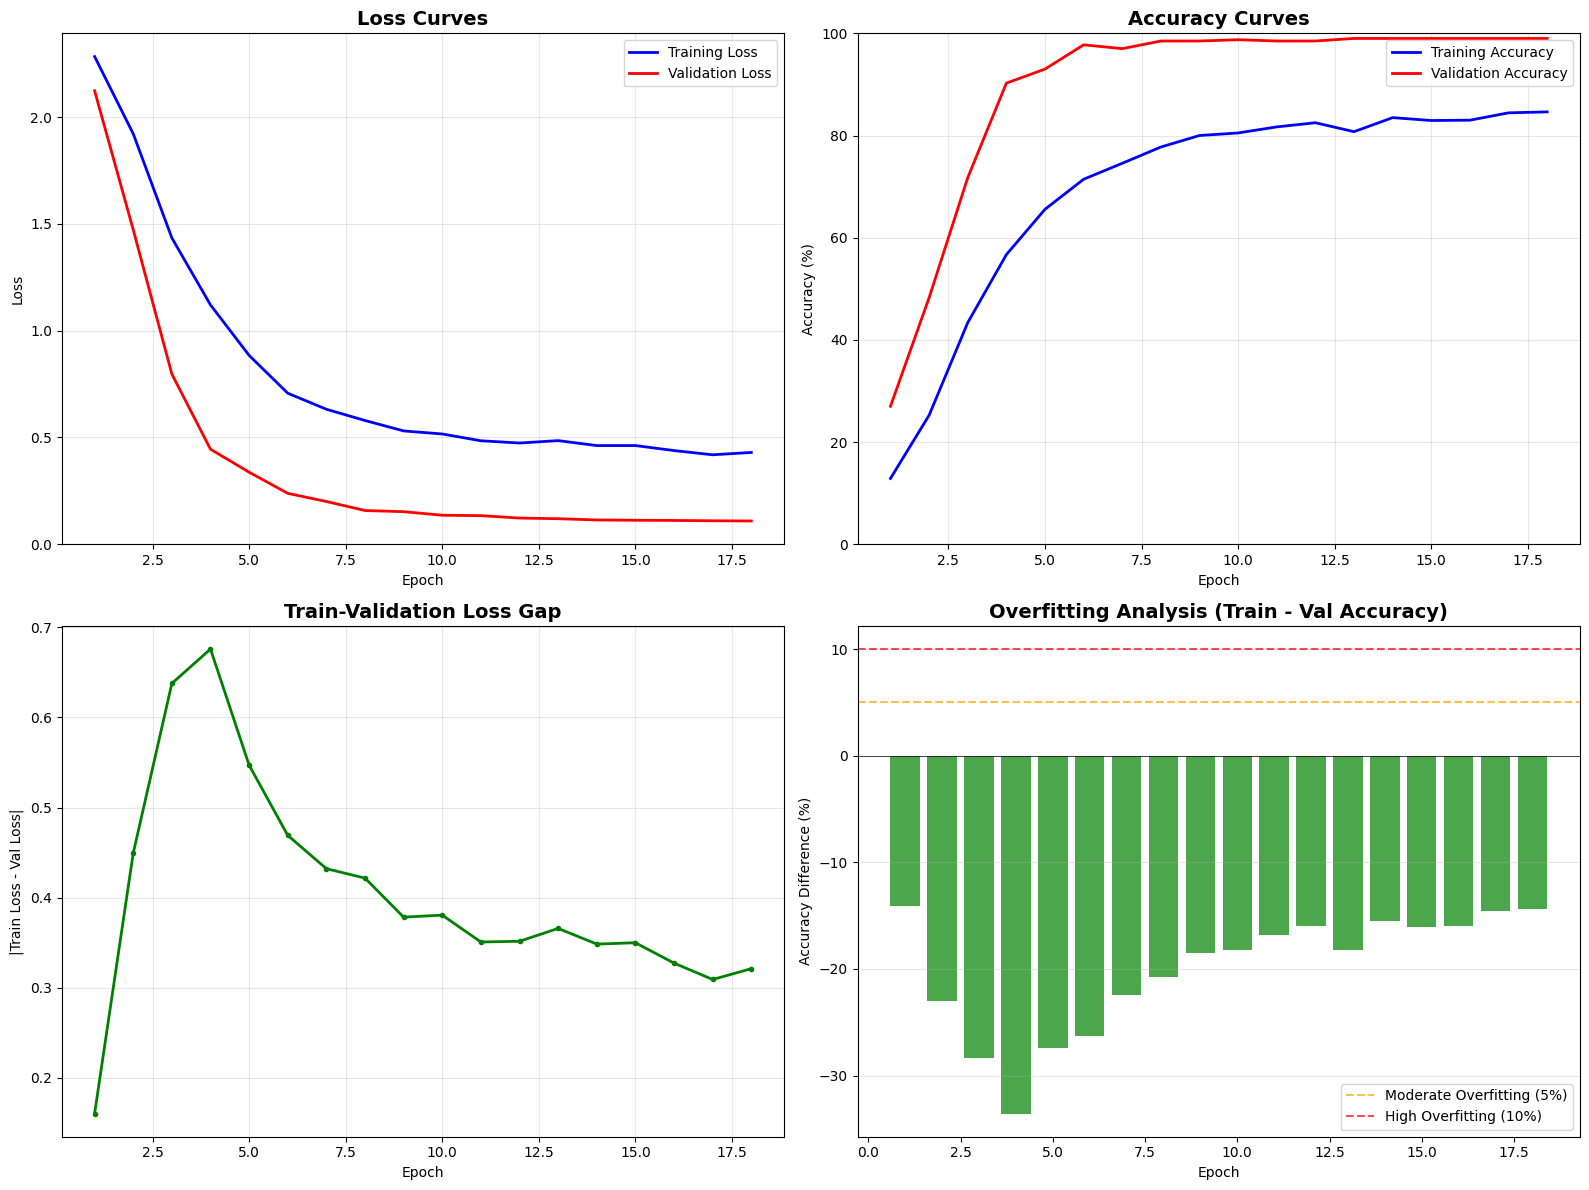


Epoch-by-Epoch Training Progress:
--------------------------------------------------------------------------------
Epoch  Train Loss   Val Loss   Train Acc    Val Acc    Gap     
--------------------------------------------------------------------------------
1      2.2837       2.1234     12.88        27.00      -14.12  
2      1.9218       1.4725     25.25        48.25      -23.00  
3      1.4341       0.7963     43.38        71.75      -28.38  
4      1.1204       0.4444     56.69        90.25      -33.56  
5      0.8840       0.3370     65.56        93.00      -27.44  
6      0.7070       0.2379     71.44        97.75      -26.31  
7      0.6318       0.1997     74.56        97.00      -22.44  
8      0.5791       0.1575     77.75        98.50      -20.75  
9      0.5303       0.1520     80.00        98.50      -18.50  
10     0.5160       0.1355     80.50        98.75      -18.25  
11     0.4842       0.1335     81.69        98.50      -16.81  
12     0.4736       0.1222     82.5

In [47]:
# Plot training curves
print("Generating training curves...")

# Basic training curves
plot_training_curves(
    train_losses, 
    val_losses, 
    train_accuracies, 
    val_accuracies,
    save_path=f'{MODEL_SAVE_PATH}/training_curves.png'
)

print("\n" + "="*60 + "\n")

# Detailed analysis
print("Generating detailed training analysis...")
plot_detailed_training_analysis(
    train_losses, 
    val_losses, 
    train_accuracies, 
    val_accuracies
)

# Additional statistics
print("\nEpoch-by-Epoch Training Progress:")
print("-" * 80)
print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<10} {'Train Acc':<12} {'Val Acc':<10} {'Gap':<8}")
print("-" * 80)

for i, (tl, vl, ta, va) in enumerate(zip(train_losses, val_losses, train_accuracies, val_accuracies)):
    gap = ta - va
    epoch_num = i + 1
    print(f"{epoch_num:<6} {tl:<12.4f} {vl:<10.4f} {ta:<12.2f} {va:<10.2f} {gap:<8.2f}")

# Learning rate effect analysis
print(f"\nLearning Rate Schedule Analysis:")
print(f"Initial LR: {LEARNING_RATE}")
print(f"Scheduler: StepLR (step_size=7, gamma=0.1)")
print(f"LR drops at epochs: 7, 14 (if training goes that long)")

# Model convergence analysis
if len(val_accuracies) >= 3:
    recent_improvement = max(val_accuracies[-3:]) - min(val_accuracies[-3:])
    if recent_improvement < 1.0:
        print(f"\n📊 Model appears to have converged (recent improvement: {recent_improvement:.2f}%)")
    else:
        print(f"\n📈 Model still improving (recent improvement: {recent_improvement:.2f}%)")